In [7]:
%run '/mnt/berger2/equipes/IGE/meom/workdir/berger2/fonctions/meom_fonctions/fonctions.ipynb'

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.netcdf as netcdf
import qgutils as qg
from matplotlib import ticker, cm
plt.ion()

In [8]:
#paramètres gravés dans le marbre pour le stage

Delta = 10000                               #grid spacing
f0 = 9.37456E-05                           #paramètre de Coriolis
dh = np.array([350,750,2900])              #hauteurs des couches océaniques
dh_b = np.array([(dh[0]+dh[1])/2,(dh[0]+dh[1])/2])
g_prime = np.array([2.5E-02,1.25E-02])     #gravités réduites aux interfaces
Beta = 1.75360E-11
delta_ek = 5                               #ocean bottom Ekman thickness 
nu4 = 2E09                                 #bi-harmonic viscosity
Ht = np.sum(dh)
Ht_b = np.sum(dh_b)
toc = np.array([1.31693E+01,1.81693E+01,2.41693E+01])
bf = delta_ek*f0/(2*dh[-1])

#fréquences Brunt-vaisala

N_12 = g_prime[0]/((dh[0]+dh[1])/2)
N_23 = g_prime[1]/((dh[1]+dh[2])/2)
N2 = np.array([N_12,N_23])

In [9]:
dir0  = '/mnt/berger2/equipes/IGE/meom/workdir/berger2/qgcm-data/double_gyre_coupled/outdata_6/'
file0 = 'ocpo.nc'
file1 = 'ocsst.nc'

In [18]:
#get fields psi
pfile = dir0 + file0

#wind forcing
forcing_z = dir0 + file1

#buyoancy forcing
forcing_b = dir0 + file1

f1 = netcdf.netcdf_file(dir0 + file0,'r')
f2 = netcdf.netcdf_file(dir0 + file1,'r')

xp = f1.variables['xp'][:-1].copy()
yp = f1.variables['xp'][:-1].copy()


In [11]:
N2,f0 = qg.reshape3d(dh,N2,f0)

si_t = f1.variables['time'][:].copy().size

p = qg.read_qgcm(pfile, 0, var='p', rescale = 1/f0, interp = True, subtract_bc = False )
nl,N,naux = p.shape

test = si_t

average = True

In [12]:
# flot moyen
flot_me = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/tableaux_termes_abs/termes_flot_moyen_abs.npz')
u_me = flot_me['u_me']
v_me = flot_me['v_me']

flot_me_bis = np.load('/mnt/berger2/equipes/IGE/meom/workdir/berger2/git/meom_test/Lorenz_cycle/tableaux_termes_abs/etapes_flot_moyen_abs.npz')
         
p_me = flot_me_bis['p_me']
b_me = flot_me_bis['b_me']

In [9]:
%%time

# compute all terms of dissipation

v_v_x_y = np.zeros((nl,N,N))
v_u_y_y = np.zeros((nl,N,N))
u_v_x_x = np.zeros((nl,N,N))
v_u_x_y = np.zeros((nl,N,N))

n_me=1

for it in range(0,test):
    
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    
    u,v = qg.comp_vel(p, Delta=Delta, loc='center')
  
    u_p = u-u_me
    v_p = v-v_me
    
    v_v_x_y = ( v_p*div_x(div_y(v_p,Delta),Delta)  -v_v_x_y)/n_me
    v_u_y_y = - (v_p * div_y(div_y(u_p, Delta), Delta)-v_u_y_y)/n_me
    u_v_x_x = (u_p*div_x(div_x(v_p, Delta), Delta)-u_v_x_x)/n_me
    v_u_x_y = - (u_p*div_y(div_x(v_p, Delta), Delta)-v_u_x_y)/n_me
                       
    n_me += 1
    

CPU times: user 1min 8s, sys: 1.52 s, total: 1min 10s
Wall time: 1min 13s


In [13]:
%%time

# compute all terms of dissipation

u_lap_v = np.zeros((nl,N,N))
v_lap_u = np.zeros((nl,N,N))

n_me=1

for it in range(0,test):
    
    p = qg.read_qgcm(pfile, it, var='p', rescale = 1/f0, interp = True, subtract_bc = True)
    
    u,v = qg.comp_vel(p, Delta=Delta, loc='center')
  
    u_p = u-u_me
    v_p = v-v_me
    
    lap_u = qg.laplacian(u_p, Delta)
    lap_v = qg.laplacian(v_p, Delta)
    
    u_lap_v = (u_p*lap_v -u_lap_v)/n_me
    v_lap_u =  (v_p*lap_u-v_lap_u)/n_me
                       
    n_me += 1
    

CPU times: user 47.1 s, sys: 4.9 s, total: 52 s
Wall time: 4min 25s


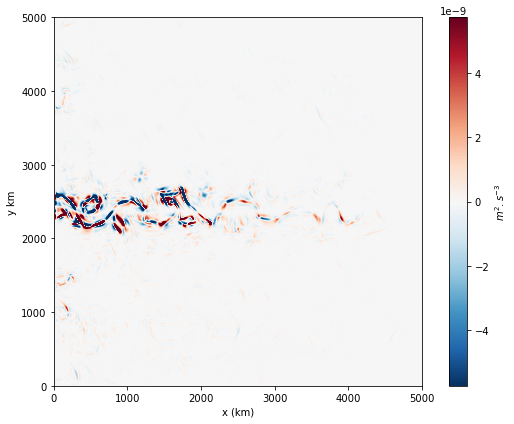

In [11]:
#mean KE to turbulent KE

#maxi = max(np.max(ke_me2ke_p_me),np.abs(np.min(ke_me2ke_p_me)))
rec_sans_i = p_me*(v_v_x_y + v_u_y_y + u_v_x_x + v_u_x_y)

rect = integral_z(rec_sans_i, dh, Delta, Ht)

#maxi=1.12e-6
maxi = max(np.max(rect), abs(np.min(rect)))

fig, ax1 = plt.subplots(1, 1, figsize = (8,6),tight_layout=True)


col = ax1.imshow( rect, cmap='RdBu_r',extent = [0,5000,0,5000], origin='lower', vmax = maxi/10, vmin = -maxi/10)
ax1.set_aspect('equal')
#ax1.set_title(r'$\overline{\overline{KE}}$ to $\overline{KEp}$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y km')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(rect)
m.set_clim(-maxi/10, maxi/10)
plt.colorbar(m, ax= ax1).set_label(r'$m^2.s^{-3}$')

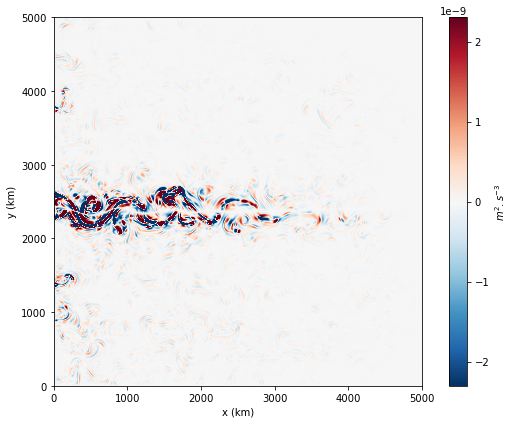

In [24]:
#mean KE to turbulent KE

#maxi = max(np.max(ke_me2ke_p_me),np.abs(np.min(ke_me2ke_p_me)))
rec_sans_i_test = p_me*(u_lap_v - v_lap_u)

rect = integral_z(rec_sans_i_test, dh, Delta, Ht)

#maxi=1.12e-6
maxi = max(np.max(rect), abs(np.min(rect)))

fig, ax1 = plt.subplots(1, 1, figsize = (8,6),tight_layout=True)


#col = ax1.contourf(xp,yp, rect, cmap='RdBu_r',levels = 50, vmax = maxi/10, vmin = -maxi/10)
col = ax1.imshow( rect, cmap='RdBu_r',extent = [0,5000,0,5000], origin='lower', vmax = maxi/15, vmin = -maxi/15)
ax1.set_aspect('equal')
#ax1.set_title(r'$\overline{\overline{KE}}$ to $\overline{KEp}$')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')

m = plt.cm.ScalarMappable(cmap='RdBu_r')
m.set_array(rect)
m.set_clim(-maxi/15, maxi/15)
plt.colorbar(m, ax= ax1).set_label(r'$m^2.s^{-3}$')